# Diagnostics Run Analysis
This notebook inspects results saved under `entropy_experiments/results/diagnostics_run`.

In [17]:
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
NOTEBOOK_DIR = Path.cwd()
RUN_ROOT = NOTEBOOK_DIR.parent
RUN_DIR = RUN_ROOT / "single_run_08-39-51"
RUN_PATTERN = "run_*"
print(f"Looking for runs under: {RUN_DIR.resolve()}")
runs = sorted(RUN_DIR.glob(RUN_PATTERN))
runs

Looking for runs under: C:\Users\phils\OneDrive\Documents\GitHub\RL_Practice\entropy_experiments\results\diagnostics_run\single_run_08-39-51


[WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_01'),
 WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_02'),
 WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_03'),
 WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_04'),
 WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_05'),
 WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_06'),
 WindowsPath('c:/Users/phils/OneDrive/Documents/GitHub/RL_Practice/entropy_experiments/results/diagnostics_run/single_run_08-39-51/run_07'),
 WindowsPath(

In [18]:
def load_run(run_dir: Path) -> dict:
    with (run_dir / "results.json").open("r") as fh:
        return json.load(fh)


In [19]:
entries = []
for run_path in runs:
    data = load_run(run_path)
    approx = data.get("approx") or {}
    delta_per_lr = approx.get("delta_h_per_lr")
    quad = approx.get("quadratic") or {}
    gdotv = quad.get("gdotv")
    vHvv = quad.get("vHvv")
    for entry in data.get("true", {}).get("entries", []):
        eta = float(entry["eta"])
        diag = entry.get("diagnostics", {}) or {}
        logw_stats = diag.get("logweight_stats") or {}
        row = {
            "run": run_path.name,
            "eta": eta,
            "delta_h_true": entry["delta_h_true"],
            "ess": diag.get("ess"),
            "clip_fraction": diag.get("clip_fraction"),
            "weights_sum": diag.get("weights_sum"),
            "base_entropy": diag.get("base_entropy"),
            "logw_min": logw_stats.get("min"),
            "logw_median": logw_stats.get("median"),
            "logw_max": logw_stats.get("max"),
        }
        if delta_per_lr is not None:
            row["delta_h_linear"] = eta * float(delta_per_lr)
        if gdotv is not None and vHvv is not None:
            row["delta_h_linquad"] = eta * float(gdotv) + 0.5 * (eta ** 2) * float(vHvv)
        entries.append(row)

if entries:
    df = pd.DataFrame(entries).sort_values(["run", "eta"])
else:
    df = pd.DataFrame(entries)
df.head()

,run,eta,delta_h_true,ess,clip_fraction,weights_sum,base_entropy,logw_min,logw_median,logw_max,delta_h_linear,delta_h_linquad
0,run_01,8.000000e-07,-0.000521,2047.308488,0.0,1916.777599,0.506524,-0.068436,-0.000004,0.066452,-0.000073,-0.000075
1,run_01,1.600000e-06,-0.000866,2046.190607,0.0,1812.853661,0.506524,-0.101616,0.000786,0.123325,-0.000146,-0.000155
2,run_01,3.200000e-06,-0.001663,2041.925435,0.0,1625.968394,0.506524,-0.232384,0.000650,0.233435,-0.000292,-0.000330
3,run_01,6.400000e-06,-0.003311,2024.874287,0.0,1324.106786,0.506524,-0.400215,-0.001411,0.441390,-0.000584,-0.000741
4,run_01,1.280000e-05,-0.006701,1958.409709,0.0,888.532867,0.506524,-0.772972,-0.010731,0.844551,-0.001169,-0.001807


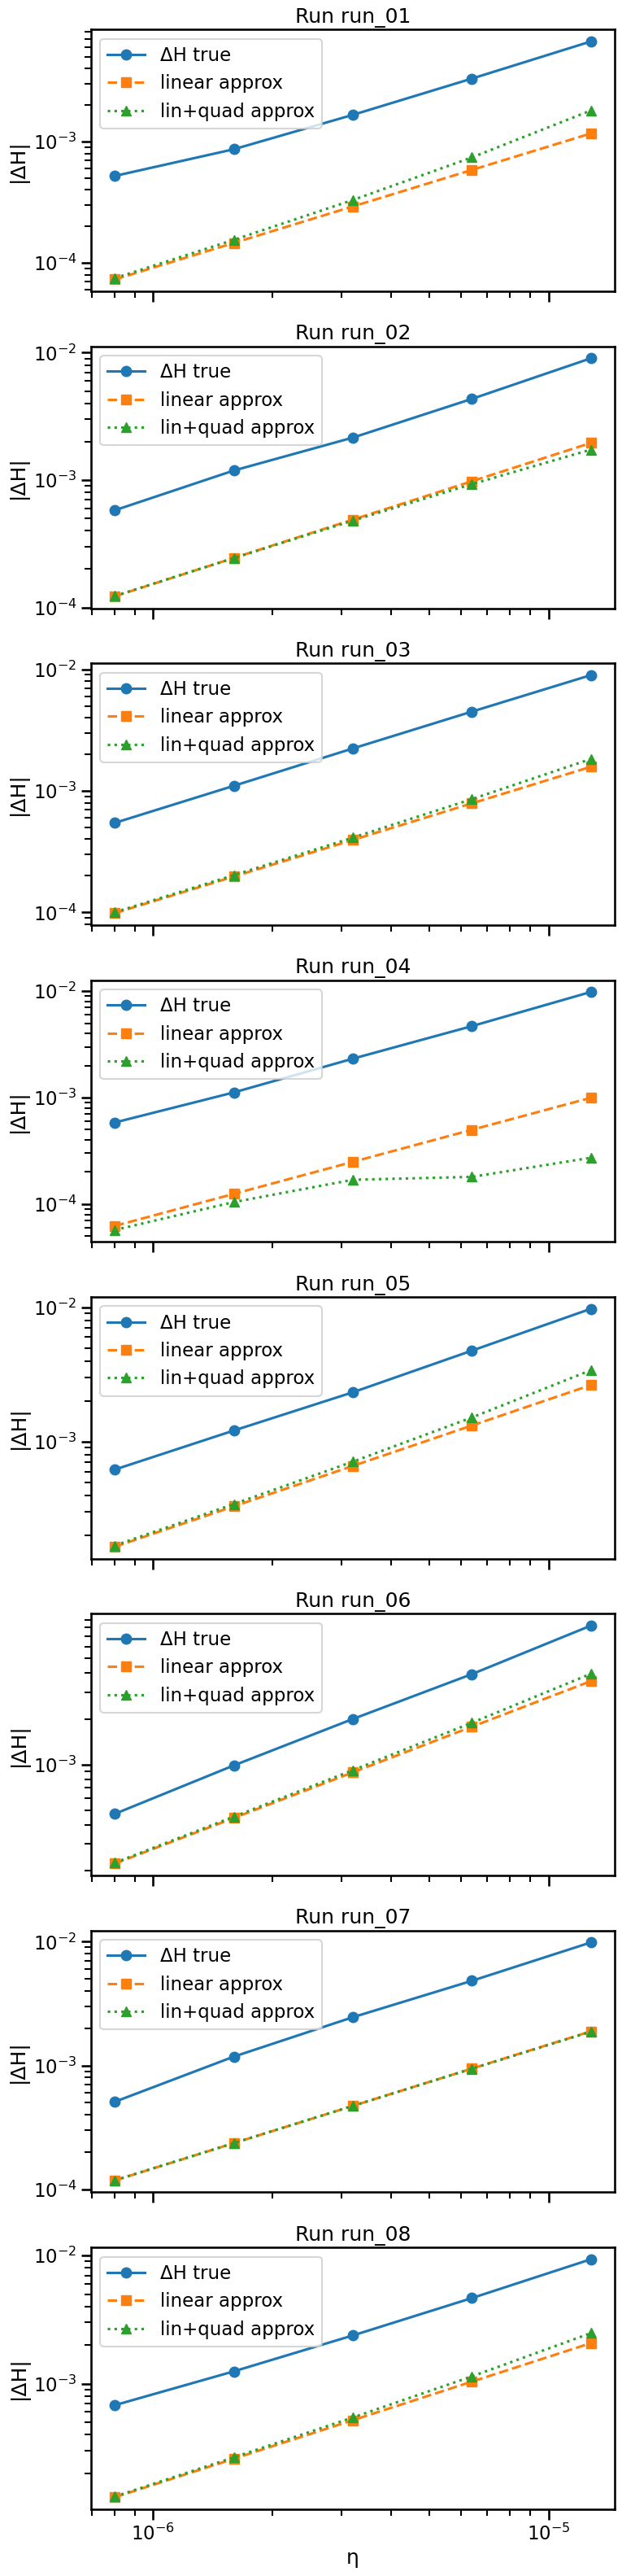

In [20]:
if df.empty:
    print('No entries found; ensure runs directory is correct.')
else:
    run_groups = df.groupby('run')
    fig, axes = plt.subplots(len(run_groups), 1, figsize=(8, 4 * len(run_groups)), sharex=True)
    if len(run_groups) == 1:
        axes = [axes]
    for ax, (run, group) in zip(axes, run_groups):
        ax.loglog(group['eta'], np.abs(group['delta_h_true']), marker='o', label='ΔH true')
        if 'delta_h_linear' in group:
            ax.loglog(group['eta'], np.abs(group['delta_h_linear']), marker='s', linestyle='--', label='linear approx')
        if 'delta_h_linquad' in group:
            ax.loglog(group['eta'], np.abs(group['delta_h_linquad']), marker='^', linestyle=':', label='lin+quad approx')
        ax.set_title(f'Run {run}')
        ax.set_ylabel('|ΔH|')
        ax.legend()
    axes[-1].set_xlabel('η')
    plt.tight_layout()
    plt.show()

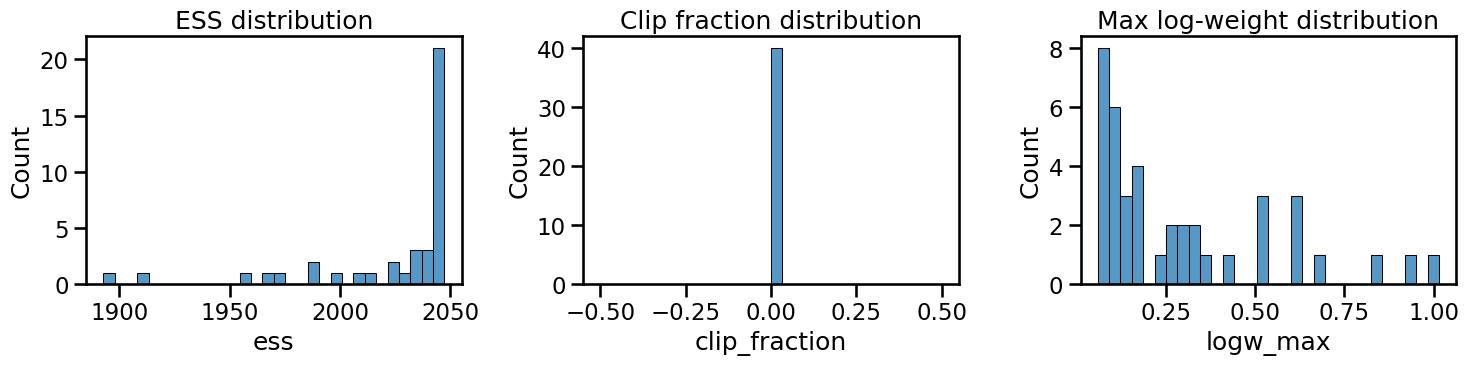

In [21]:
if not df.empty:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(df['ess'].dropna(), bins=30, ax=axs[0]); axs[0].set_title('ESS distribution')
    sns.histplot(df['clip_fraction'].dropna(), bins=30, ax=axs[1]); axs[1].set_title('Clip fraction distribution')
    sns.histplot(df['logw_max'].dropna(), bins=30, ax=axs[2]); axs[2].set_title('Max log-weight distribution')
    plt.tight_layout(); plt.show()

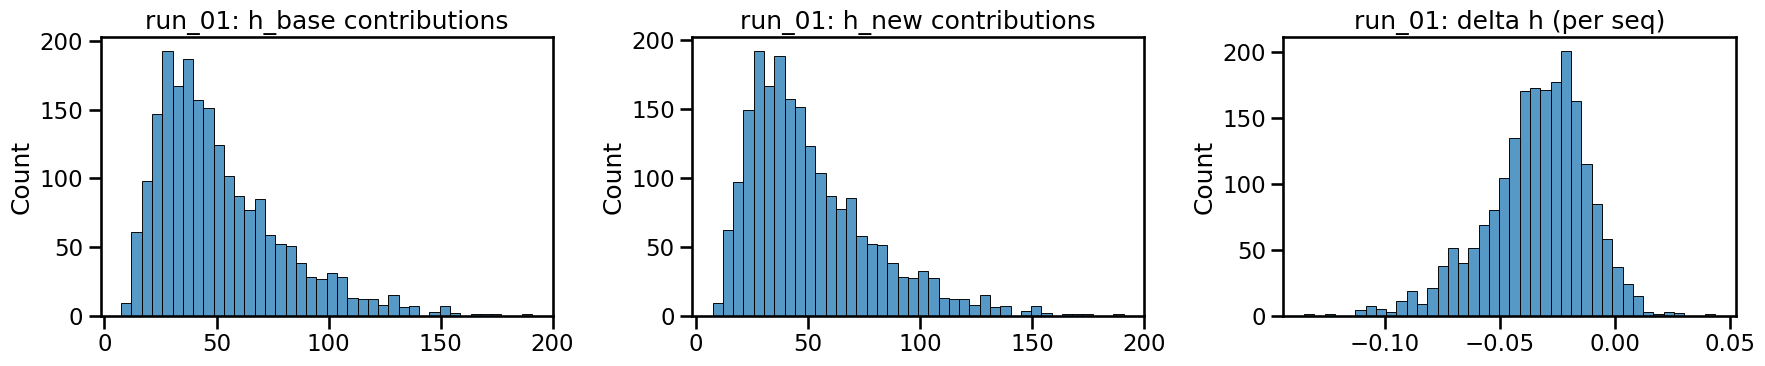

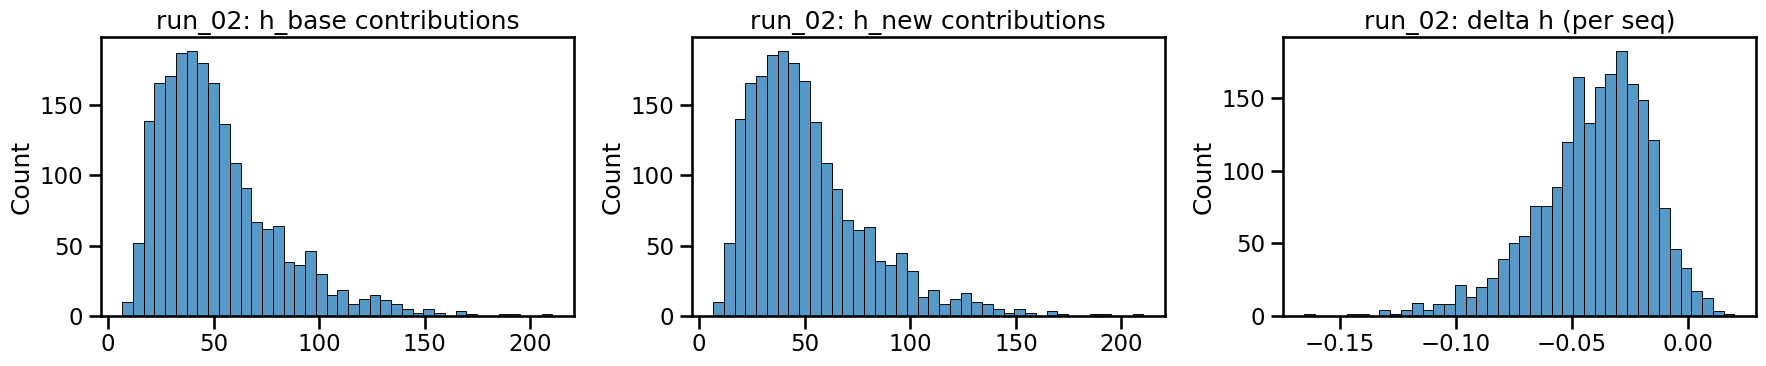

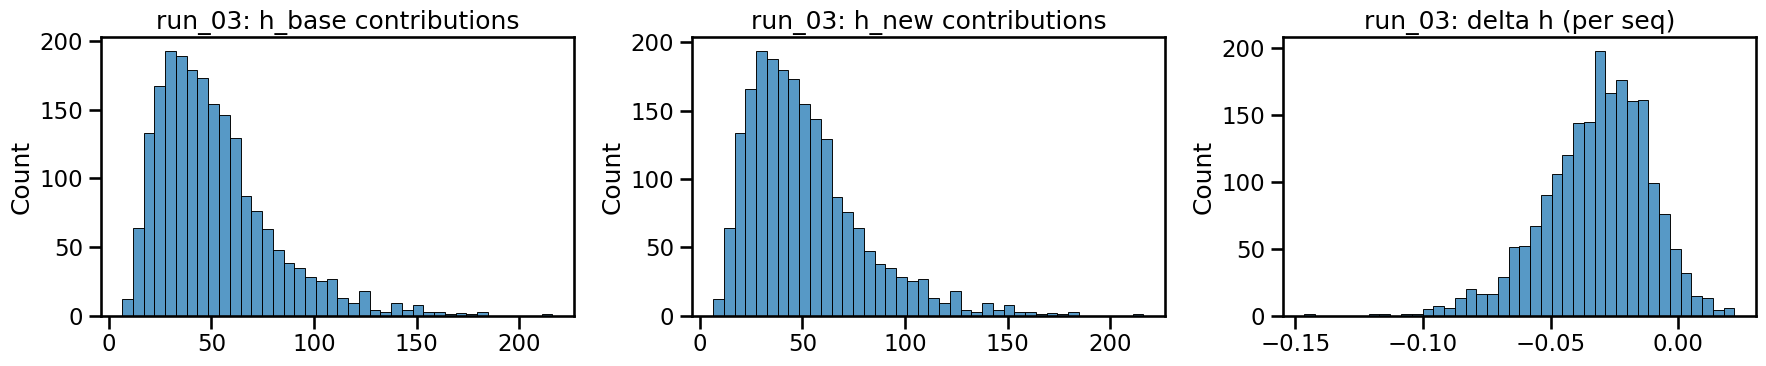

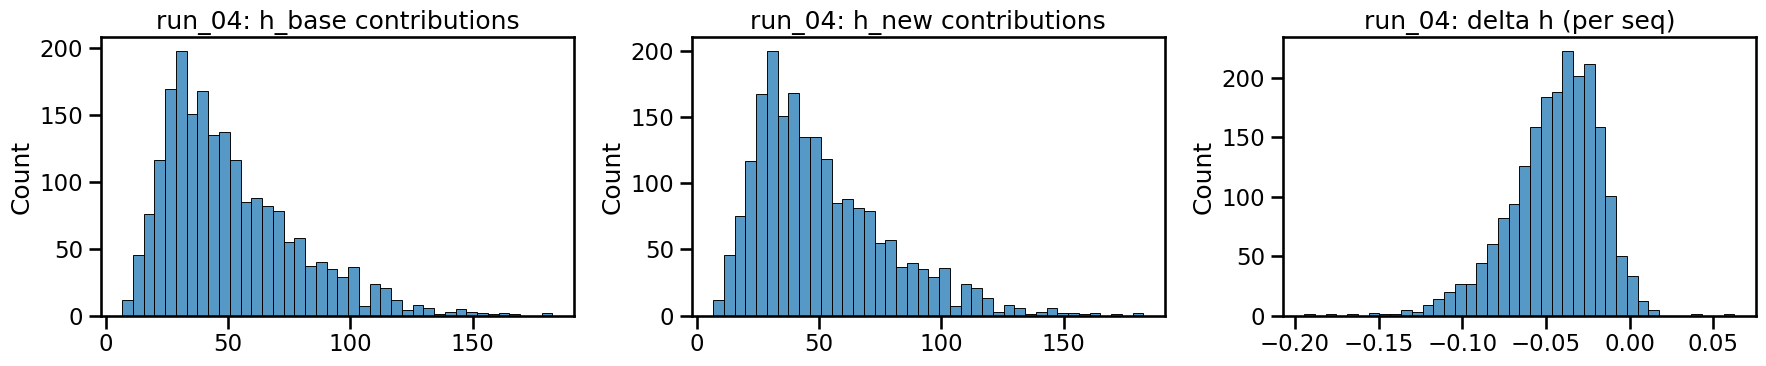

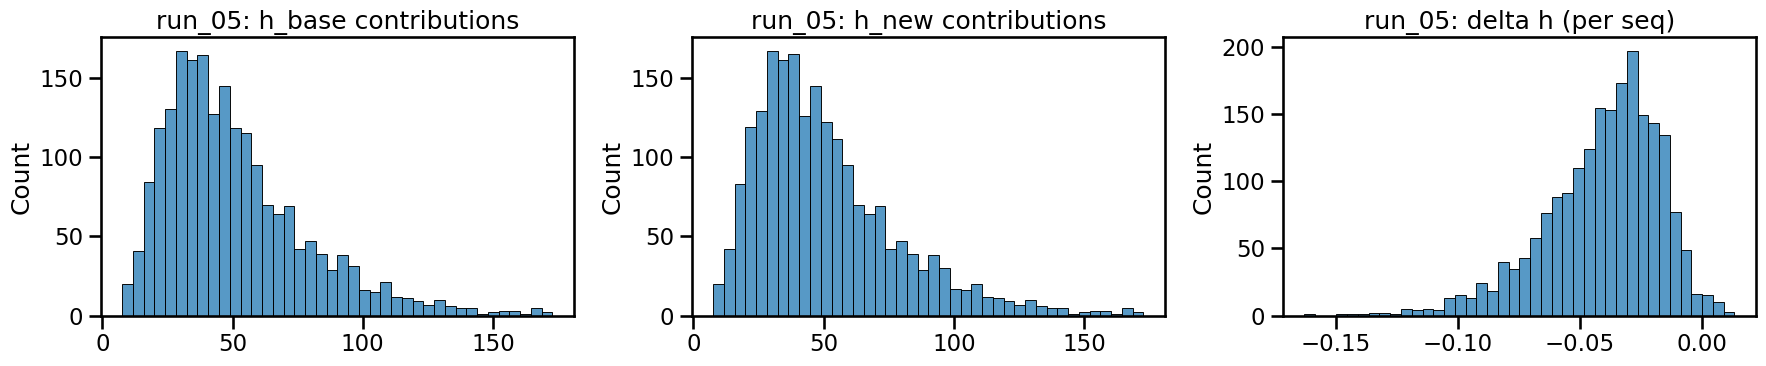

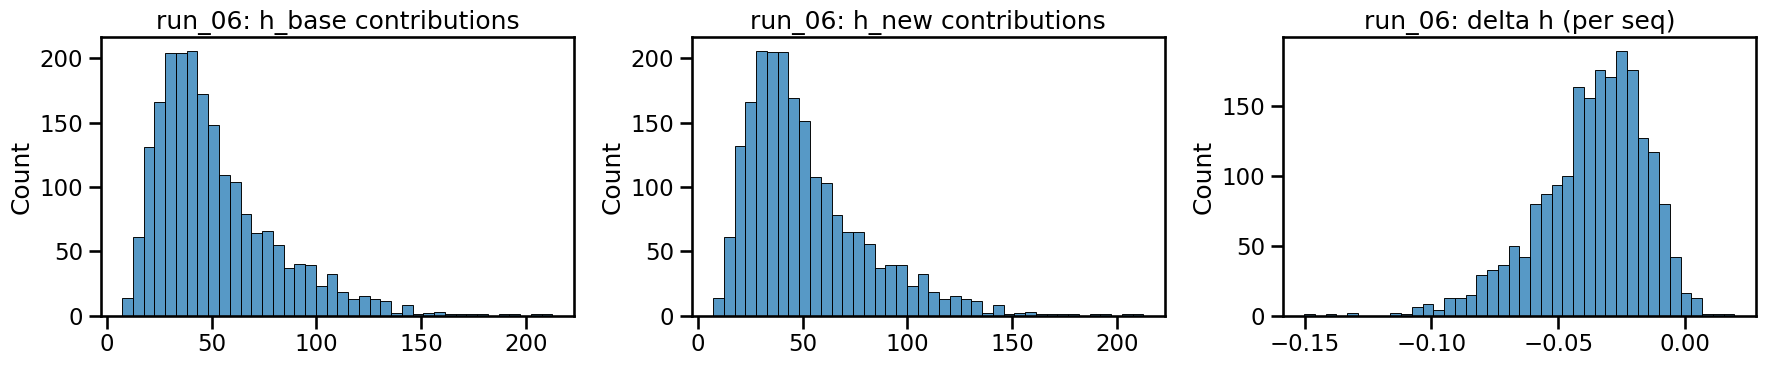

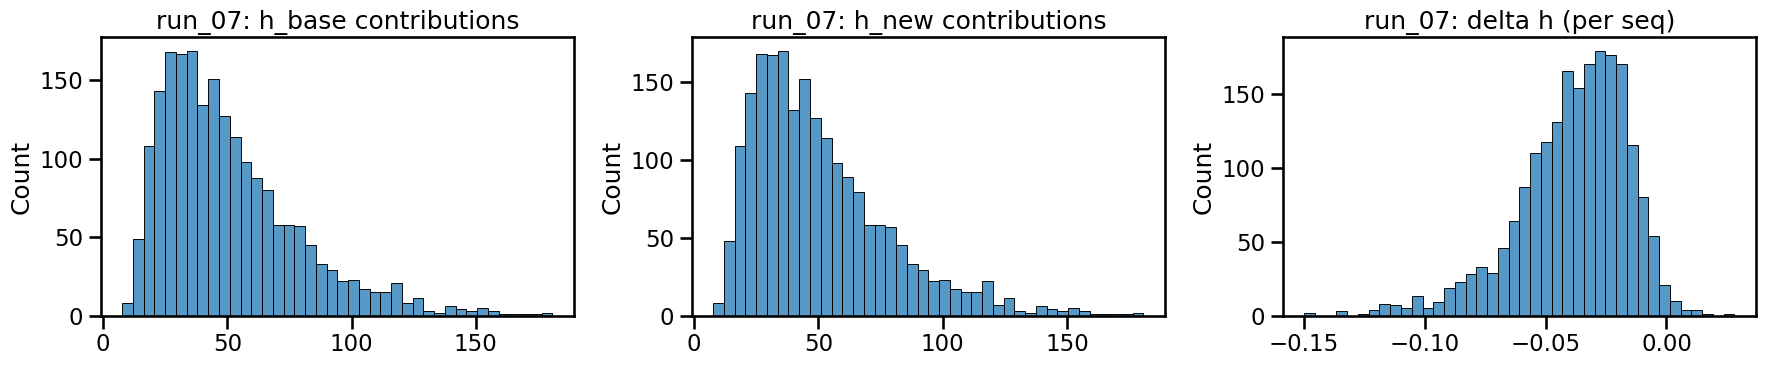

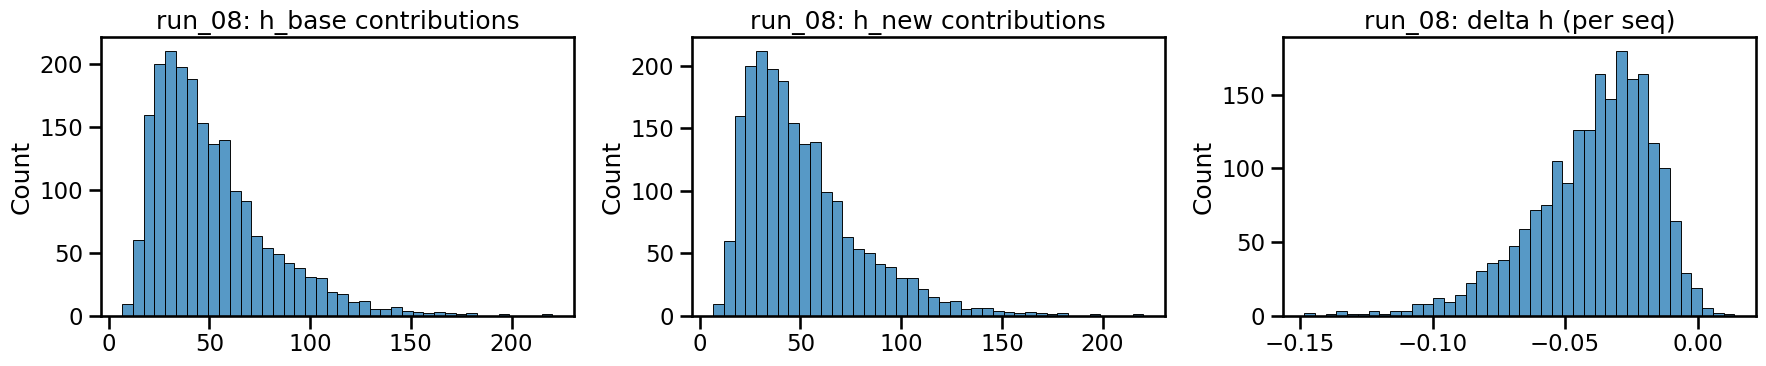

In [22]:

# Per-sequence h_base, h_new, and delta for each run
RUNS = sorted(RUN_DIR.glob(RUN_PATTERN))

for run_path in RUNS:
    data = load_run(run_path)
    entries = data.get('true', {}).get('entries', [])
    if not entries:
        continue
    for entry in entries:
        diag = entry.get('diagnostics', {}) or {}
        if 'h_base' in diag and 'h_new' in diag and 'delta_h_seq' in diag:
            h_base = np.asarray(diag['h_base'], dtype=float)
            h_new = np.asarray(diag['h_new'], dtype=float)
            delta_seq = np.asarray(diag['delta_h_seq'], dtype=float)
            fig, axes = plt.subplots(1, 3, figsize=(18, 4))
            sns.histplot(h_base, bins=40, ax=axes[0])
            axes[0].set_title(f"{run_path.name}: h_base contributions")
            sns.histplot(h_new, bins=40, ax=axes[1])
            axes[1].set_title(f"{run_path.name}: h_new contributions")
            sns.histplot(delta_seq, bins=40, ax=axes[2])
            axes[2].set_title(f"{run_path.name}: delta h (per seq)")
            plt.tight_layout()
            plt.show()
            break
